# E2a: Küchentischversuch zum Laval-Rotor

Name:  Fabian Roesch
Datum:  11.01.2024

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:

Ist der Pi in der gegebenen Konfiguration in der lage alltägliche Schwingungen zu messen?

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="heimversuch1.jpeg" width="400">

- Beschreibung des Aufbaus:
Der Sensor wird mit einem improvisierten gewicht auf dem Handy fixiert

- Vorgangsbeschreibung:
Die Messung wird gestartet, danach wird die Vibration am Handy gestartet. Vor Ende der Messzeit wird die Vibration gestoppt.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [1]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

## import didnt work correctly, copied functions as a workaround

import numpy as np
from numpy.fft import fft, ifft
from typing import Tuple


def get_vec_accel(x: np.ndarray, y: np.ndarray, z: np.ndarray) -> np.ndarray:
   
    x_beschl_q2 = np.square(x)
    y_beschl_q2 = np.square(y)
    z_beschl_q2 = np.square(z)

    abs_beschl = np.sqrt(x_beschl_q2 + y_beschl_q2 + z_beschl_q2)

    return abs_beschl

def interpolation(time: np.ndarray, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    
    interpolation_time = np.linspace(np.min(time), np.max(time), len(time))
    interpolated_data = np.interp(interpolation_time, time, data)
    return interpolated_data

def my_fft(x: np.ndarray, time: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    
    mittelwert = np.mean(x)
    daten_null_mittelwert = x-mittelwert


    x = daten_null_mittelwert    # altes x überschreiben
    sr = len(time)/(np.max(time)-np.min(time))

    X = fft(x)
    N = len(X)
    n = np.arange(N)
    T = N/sr
    freq = n/T 

# Get the one-sided specturm
    n_oneside = N//2
# get the one side frequency
    f_oneside = freq[:n_oneside]

# normalize the amplitude
    X_oneside =X[:n_oneside]/n_oneside
    
    return X_oneside, f_oneside


#### 1a. Einlesen der Mess- und Metadaten

In [2]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "measurement_data/data_20240111_134825_FabianRoesch_Handy" # replace None by the relative path to the first object's folder
h5_file_name = "data_20240111_134825_FabianRoesch_Handy.h5" # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

In [3]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240111_134825_FabianRoesch_Handy/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240111_134825_FabianRoesch_Handy/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240111_134825_FabianRoesch_Handy/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeb0755-fae3-65c5-b9ca-8187b30cc48c": {
    "type": "probe",
    "name": "Handy",
    "comment": "",
    "path": "measurement_data/data_2

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [4]:
path = "measurement_data/data_20240111_134825_FabianRoesch_Handy/data_20240111_134825_FabianRoesch_Handy.h5"

#h5 auslesen

f = h5py.File(path, 'r')
data = f['RawData']
time = np.array(data["timestamp"])
xa = np.array(data["acceleration_x"])
ya = np.array(data["acceleration_y"])
za = np.array(data["acceleration_z"])

#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [5]:
acc = get_vec_accel(xa,ya,za)
print(acc)

[10.16392923 10.16392923 10.15453866 ... 10.12152703 10.14794492
 10.14794492]


#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

Text(0, 0.5, 'Zeitabstände [s]')

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


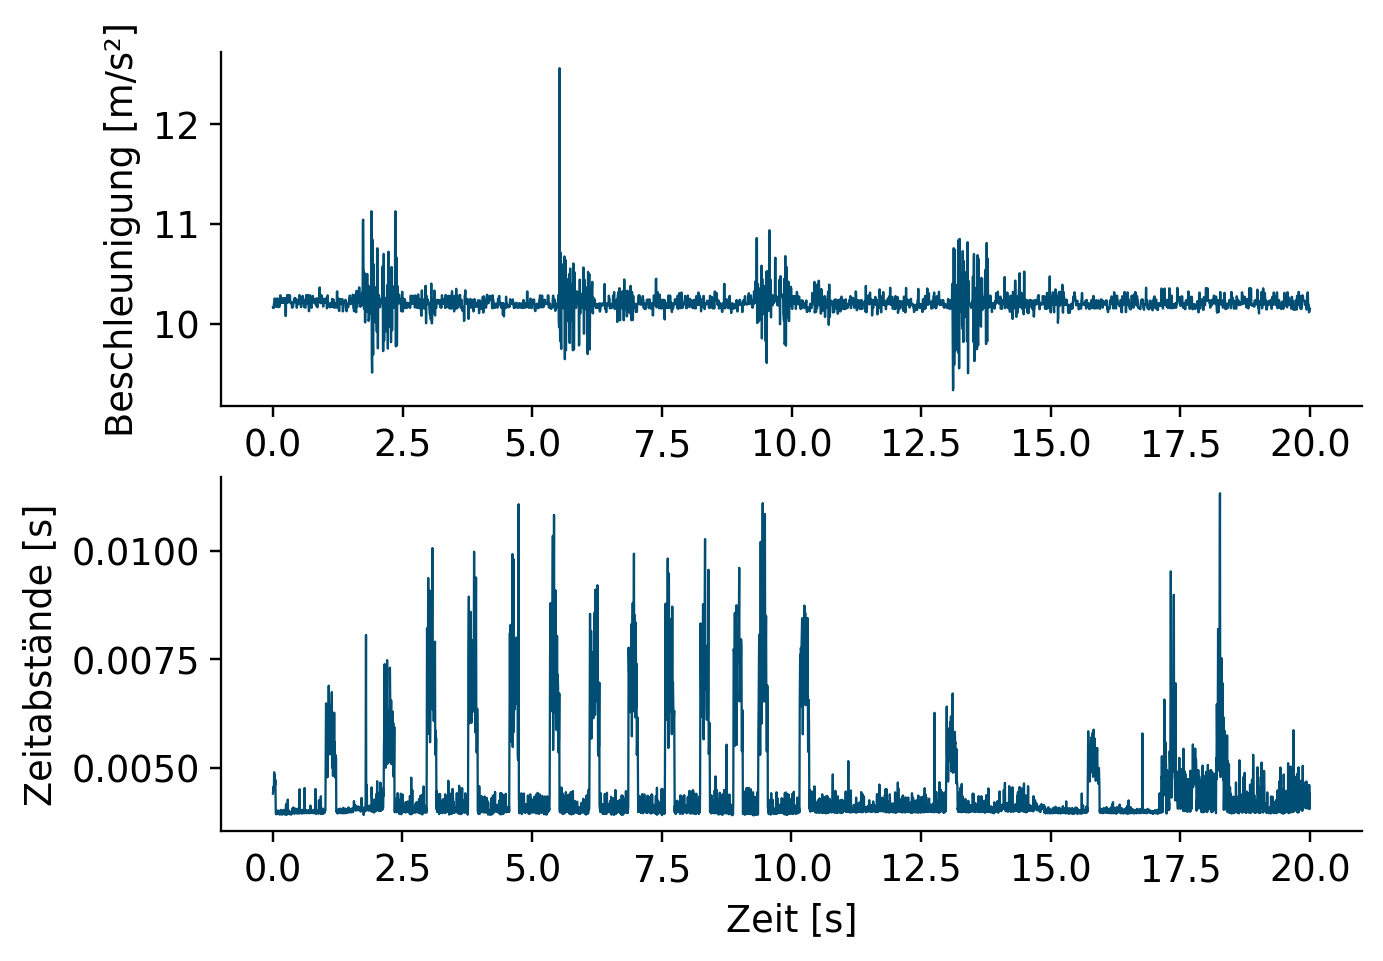

In [6]:
fig,(ax1,ax2) = plt.subplots(2,1)
ax1.plot(time, acc)
ax1.set_xlabel('Zeit [s]')
ax1.set_ylabel('Beschleunigung [m/s²]')

diff = np.diff(time)
time_1 = time[1:]

ax2.plot(time_1,diff)
ax2.set_xlabel('Zeit [s]')
ax2.set_ylabel('Zeitabstände [s]')


#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [7]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.

interp_data = interpolation(time, acc)
print(interp_data)
print(time)

[10.16392923 10.16392923 10.15496956 ... 10.12152703 10.14685195
 10.14794492]
[0.00000000e+00 4.41384315e-03 8.91995430e-03 ... 1.99881494e+01
 1.99925802e+01 1.99967535e+01]


#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

Text(0, 0.5, 'Amplitude')

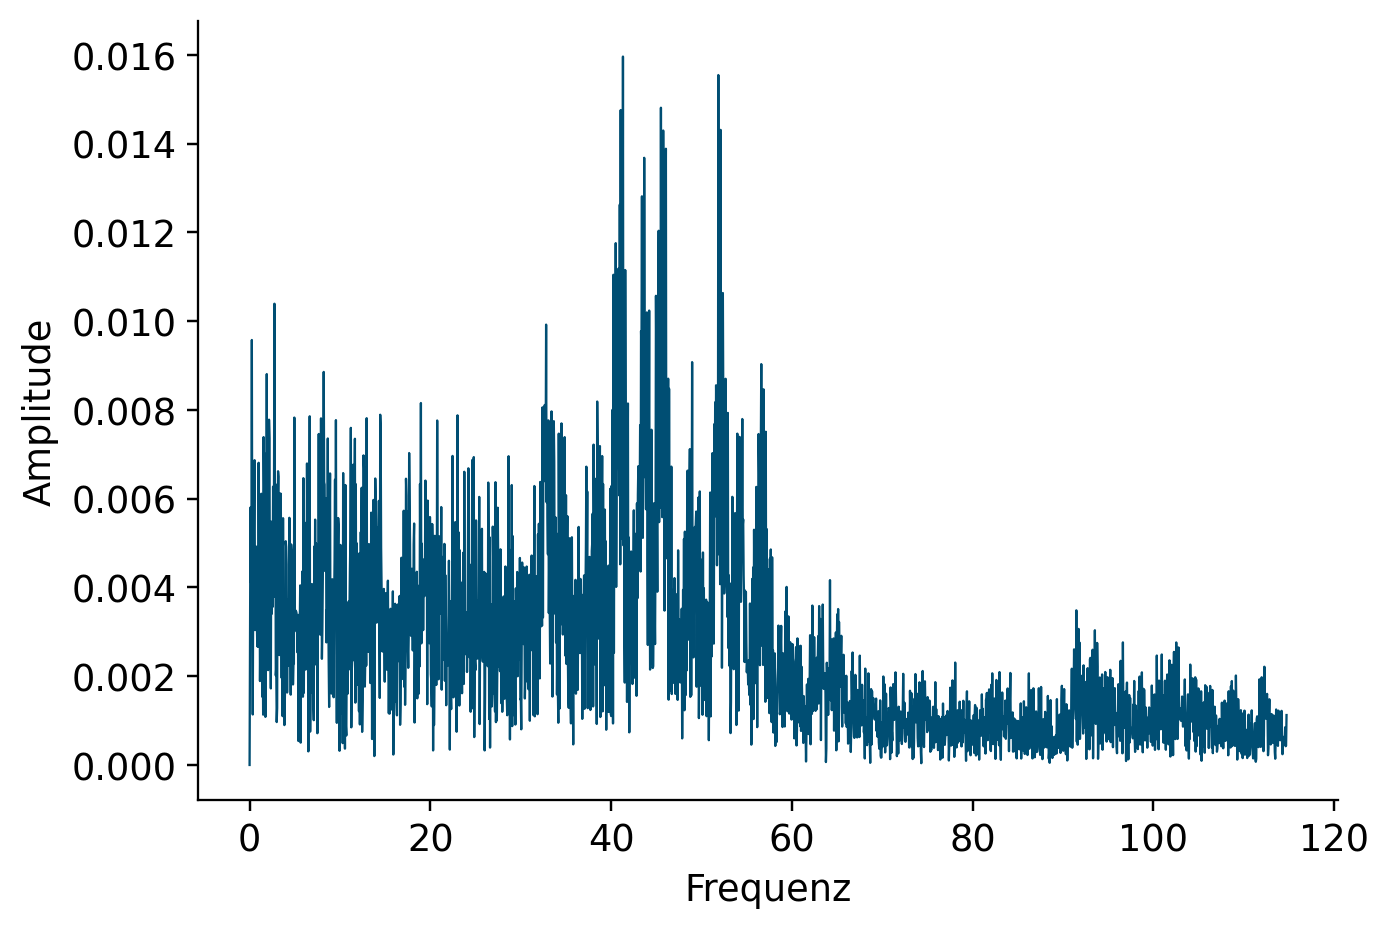

In [8]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

fre, amp = my_fft(interp_data, time)
fig2 =plt.figure()
plt.plot(amp, np.abs(fre))
plt.xlabel('Frequenz')
plt.ylabel('Amplitude')



# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Gegenstands:

<img src="heimversuch2.jpeg" width="400">

- Beschreibung des Aufbaus:
Der zu vermessende Elektromotor ist auf einer holzplatte Fixiert. Auf der selben Platte wurde auch der Sensor mit Reißzwecken befestigt.
- Vorgangsbeschreibung:
Die Messung wird gestartet, dann wird die E-Maschiene gestartet, und vor Ende der Messung wieder gestoppt

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [23]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folderb = "measurement_data/data_20240111_140828_FabianRoesch_EMotor" # replace None by the relative path to the first object's folder
h5_file_nameb = "data_20240111_140828_FabianRoesch_EMotor.h5" # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folderb
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240111_140828_FabianRoesch_EMotor/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240111_140828_FabianRoesch_EMotor/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240111_140828_FabianRoesch_EMotor/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeb081f-f0cb-6225-b049-0382ace089af": {
    "type": "probe",
    "name": "EMotor",
    "comment": "",
    "path": "measurement_data/da

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [24]:
pathb = "measurement_data/data_20240111_140828_FabianRoesch_EMotor/data_20240111_140828_FabianRoesch_EMotor.h5"

#h5 auslesen

fb = h5py.File(pathb, 'r')
datab = fb['RawData']
timeb = np.array(data["timestamp"])
xb = np.array(datab["acceleration_x"])
yb = np.array(datab["acceleration_y"])
zb = np.array(datab["acceleration_z"])

print(xb)
print(xa)

[-0.196133  -0.1176798 -0.1569064 ... -0.1569064 -0.2745862 -0.196133 ]
[-1.2552512 -1.2552512 -1.176798  ... -1.2160246 -1.1375714 -1.1375714]


#### 2. Betrag der Beschleunigung berechnen


In [25]:
accb = get_vec_accel(xb,yb,zb)
print(accb)

[9.86539242 9.97937348 9.94299527 ... 9.93866119 9.93928046 9.9356417 ]


#### 3. Darstellung der Messdaten

Text(0, 0.5, 'Zeitabstände [s]')

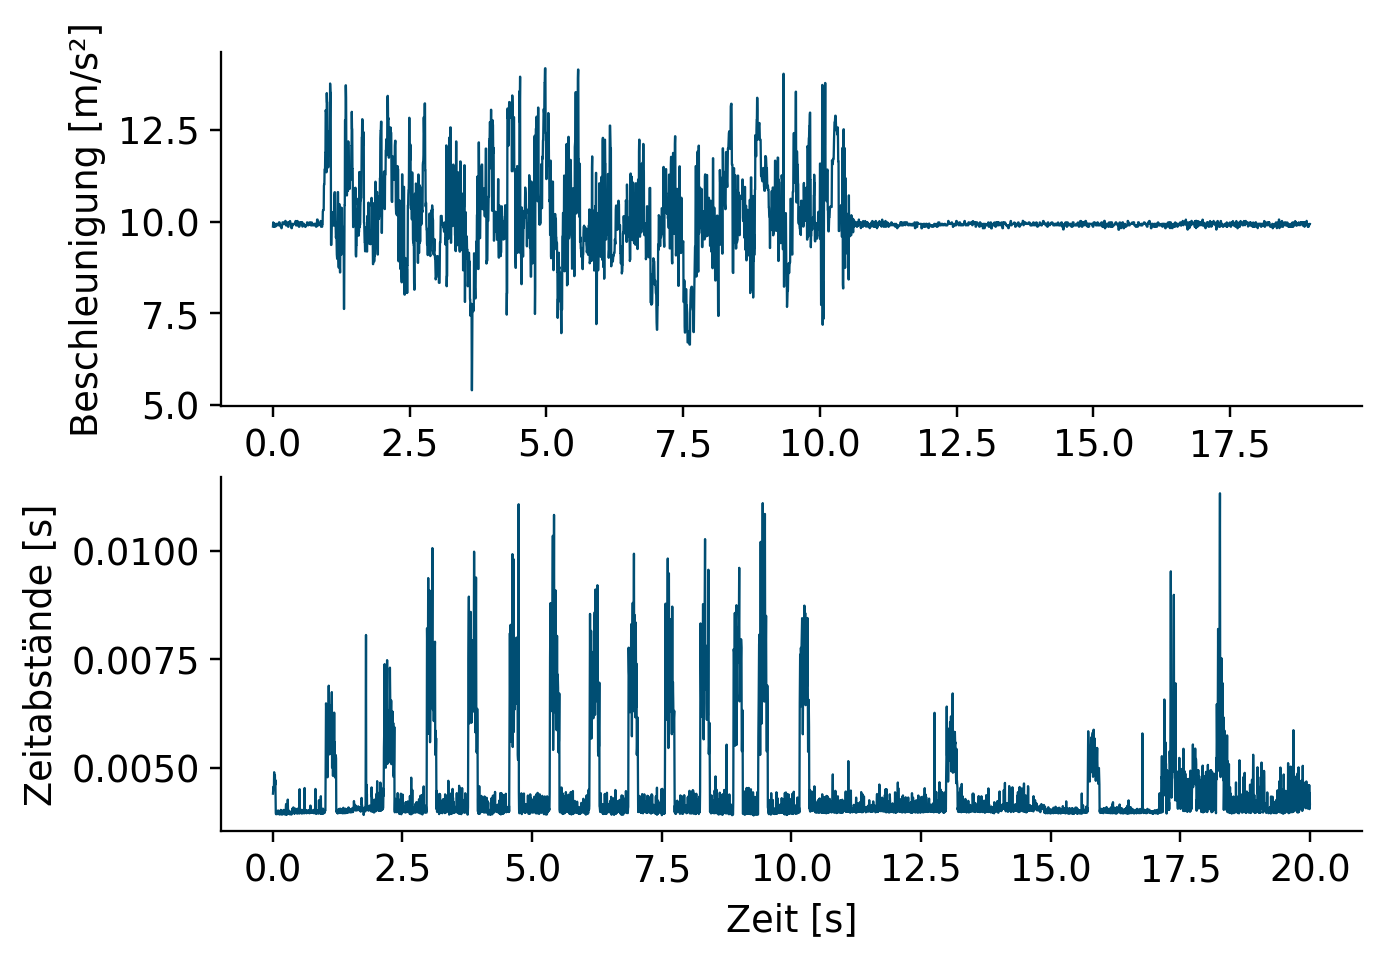

In [31]:
fig,(ax1,ax2) = plt.subplots(2,1)

timec = np.resize(timeb, 4345)

ax1.plot(timec, accb)
ax1.set_xlabel('Zeit [s]')
ax1.set_ylabel('Beschleunigung [m/s²]')

diffb = np.diff(timeb)
time_1b = timeb[1:]

ax2.plot(time_1b,diffb)
ax2.set_xlabel('Zeit [s]')
ax2.set_ylabel('Zeitabstände [s]')

#### 4. Interpolation der Messwerte



In [32]:
interp_datab = interpolation(timec, accb)
print(interp_datab)
print(timec)

[9.86539242 9.97808535 9.94454556 ... 9.93866119 9.93922712 9.9356417 ]
[0.00000000e+00 4.41384315e-03 8.91995430e-03 ... 1.89488957e+01
 1.89530413e+01 1.89570482e+01]


#### 5 & 6. FFT durchführen und graphisch darstellen


Text(0, 0.5, 'Amplitude')

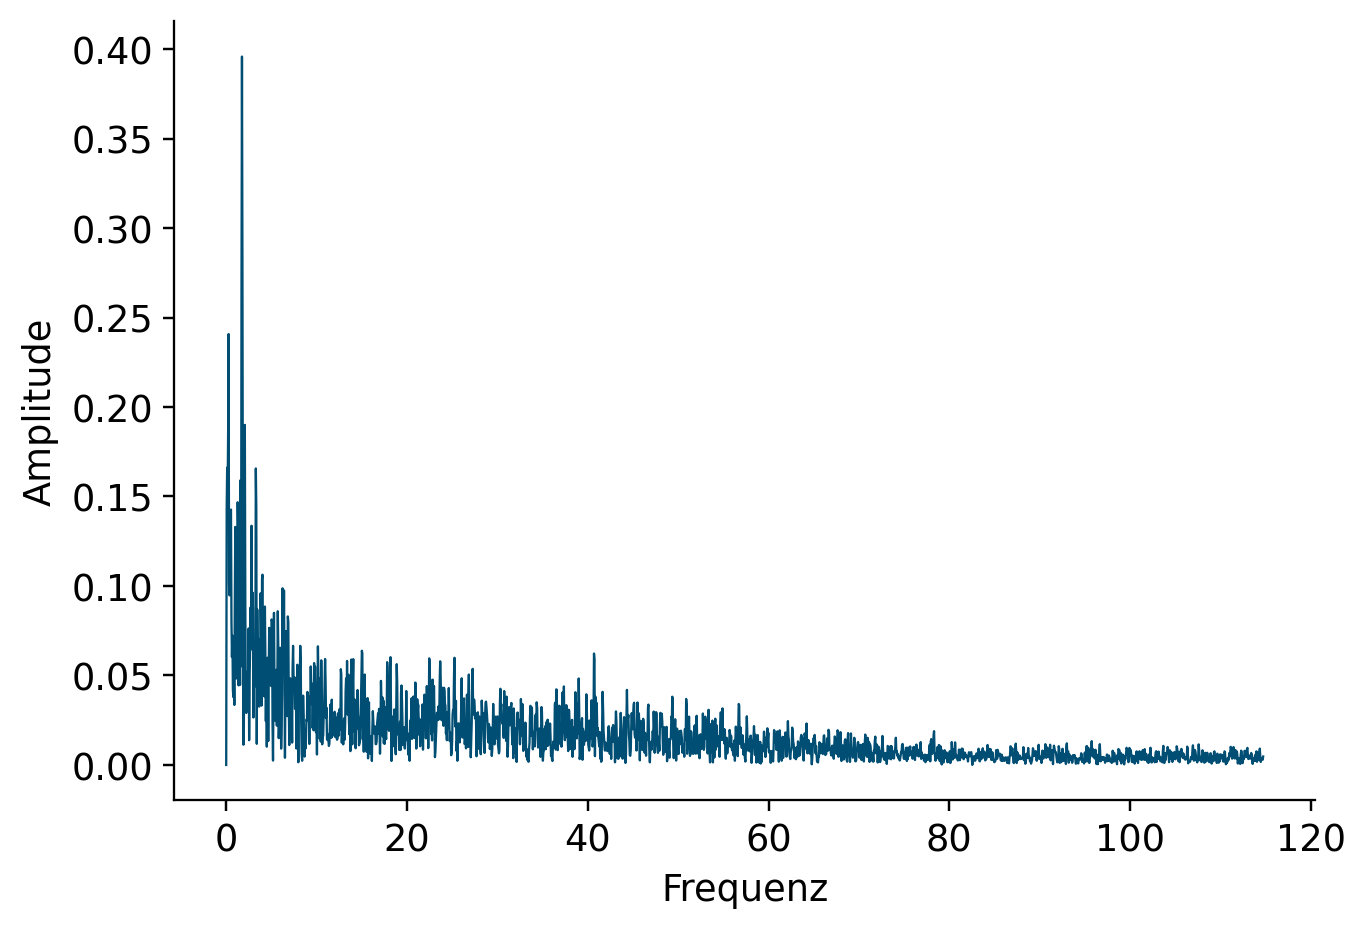

In [33]:
freb, ampb = my_fft(interp_datab, timeb)
fig3 =plt.figure()
plt.plot(ampb, np.abs(freb))
plt.xlabel('Frequenz')
plt.ylabel('Amplitude')

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Es ist ein klarer Unterschied in den Versuchsdaten zu erkennen. Die Handy-Daten folgen einem bestimmtem Muster, das den Vibrationseinstellungen des Weckers entspricht. Die Daten aus der EMotor Messung zeigen eine deutlich Stärkere Vibration die keinem Muster entspricht. Bezüglich der Forschungsfrage kann festgehalten werden, dass das Pi in der vorliegenden Konfiguration gut zum Messen solcher Schwingungen genutzt werden kann, da beide Grafiken sauber (bis auf wenige Ausreisser) aussehen, und klara Charakteristika erkennbar sind.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Dieser Versuch war für mich sehr viel angenehmer und interessanter als die beiden anderen. Ich konnte alles ohne große Probleme bearbeiten, und neue Befehle lernen. Einige Fehler die ich in den anderen Abgaben gemacht habe konnte ich hier beseitigen, etwa durch np.resize().